## Score Model w/ Weather EDA

### Objective

* Evaluation of basic linear model using weather factors and previous scores

### Rationale

*  Why This?  Before establishing a baseline model, the performance implications of various model choices need to be explored.

*  Why Me?  Because I will be building the baseline model, I am the logical choice

*  Why Now?  Data from a reproducible pipeline is now available; understanding model choices is necessary before continuing on the project critical path of model implementation

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks/eda`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/linear_model_fits.csv`

### Import / Set-Up

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
0,0,2019-07-31,72.794321,126.976852,1.506636,5.644444,48.045432,0.0,0.300855,0.144409,3.164691,70.721472,131.495746,0
1,1,2019-07-30,65.809722,138.952160,1.881636,5.822222,57.332562,0.0,0.324830,0.028351,0.959506,317.104579,264.772811,1
2,2,2019-07-29,66.465895,131.240741,1.744599,5.922222,58.189043,0.0,0.186293,-0.201019,0.232840,20.763117,1.547547,1
3,3,2017-02-25,51.399839,263.967874,1.268378,8.522222,65.060386,0.0,-1.164293,-0.069125,6.541728,325.376581,3147.061947,2
4,4,2019-07-04,58.500000,223.000000,3.700000,7.800000,86.300000,0.0,-2.523394,-2.706009,0.000000,0.000000,0.000000,2


In [4]:
scores_df.head()

,id,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53,-1.50,51.50,2019-01-19 08:00:00,1


In [5]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'id')

In [6]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [7]:
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
0,Alex Torres,68,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Drop any rows that do not have weather data
all_df = all_df.dropna(subset = ['weighted_T'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var
478,Ben Horst,65,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
479,Bob Montes,54,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
480,Dennis Warsen,52,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
481,Gonzalo Arestizabal,63,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685
482,Greg Mann,58,NaN,NaN,2017-01-28 09:00:00,2,2017-01-28,53.789346,251.602328,1.089775,7.688889,64.358531,0.0,-0.963792,-0.419697,0.134321,28.786247,2.475685


In [9]:
len(all_df)

987

In [10]:
all_df.columns

Index(['Name', 'Raw', 'Handicap', 'Adjusted', 'time', 'course_id', 'date',
       'weighted_T', 'weighted_w_dir', 'weighted_w_spd', 'weighted_w_gust',
       'weighted_rh', 'weighted_precip', 'weighted_w_u', 'weighted_w_v',
       'w_gust_var', 'w_dir_var', 'w_uv_var'],
      dtype='object')

In [11]:
def model_player_performance(player : str, course : int):
    """Given a player name and course id, return model parameters indicating the effects of weather on expected score.
    The model will return a dictionary with coefficients for easy identification"""
    
    model_dict = {}
    model_dict['player'] = player
    model_dict['course_id'] = course
    player_df = all_df[(all_df['Name'] == player) & (all_df['course_id'] == course)]
    # Stop early if no games are found
    if len(player_df) == 0:
        model_dict['nomatch'] = 1
        return model_dict
    # else...
    # Replace index with the cumulative number of games played, and make that into a column
    player_df = player_df.reset_index()
    player_df = player_df.drop(columns = ['index'])
    player_df = player_df.reset_index()
    model_dict['n_values'] = len(player_df)
    # Set list to hold model items and coefficient names
    model_factors = ['index','weighted_T','weighted_w_spd','weighted_w_gust','weighted_precip','w_dir_var']
    coeff_names = ['cumgame_coeff','T_coeff','wspd_coeff','wgust_coeff','precip_coeff','dirvar_coeff']
    # Assumes first factor will be time-dependent and the rest weather-dependent
    # Check for any weather variable that is highly correlated with time (i.e. model_factor[0]) and remove it
    removed_corr = 0
    for ix, factor in enumerate(model_factors):
        if ix == 0:
            continue
        corr = player_df.corr()[model_factors[0]][factor]
        if corr > 0.8:
            model_factors.pop(ix)
            coeff_names.pop(ix)
            removed_corr += 1
    model_dict['removed_corr'] = removed_corr
    if not(model_factors):
        model_dict['no_uncorrelated'] = 1
        return model_dict
    # else...
    # If the number of data points is too small, go with time-dependence only
    if len(model_factors) > len(player_df) - 2:
        model_factors = ['index']
        coeff_names = ['cumgame_coeff']
    X = player_df[model_factors].values
    y = player_df['Raw'].values
    # Fit if there are enough values, fit with ElasticNet
    if len(player_df) > 3:
        scaler = StandardScaler()
        lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, 
                        max_iter = 5000, random_state=42)
        pipeline = make_pipeline(scaler, lr)
        pipeline.fit(X,y)
        ypred = pipeline.predict(X)
        model_dict['prediction_score'] = pipeline.score(X,y)
        scaled_coeff = pipeline['elasticnetcv'].coef_ 
        coeff_tuple = np.true_divide(scaled_coeff, pipeline['standardscaler'].scale_)
        for ix, coeff in enumerate(coeff_tuple):
            model_dict[coeff_names[ix]] = coeff_tuple[ix]
        scaled_intercept = pipeline['elasticnetcv'].intercept_
        model_dict['intercept'] = scaled_intercept - np.dot(coeff_tuple, pipeline['standardscaler'].mean_)
        model_dict['mse'] = mean_squared_error(y, ypred)
    else:  #Just use average value
        model_dict['intercept'] = np.mean(y)
        model_dict['mse'] = np.std(y)
        
    return model_dict    

In [12]:
#Make list of player names
player_names = all_df['Name'].unique()
perf_dicts = []
for player_name in player_names:
    for course_id in range(all_df['course_id'].max() + 1):
        perf_dict = model_player_performance(player_name, course_id)
        perf_dicts.append(perf_dict)
            
perf_model_df = pd.DataFrame(perf_dicts)
perf_model_df.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  tol, rng, random, positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
0,NaN,0,NaN,NaN,NaN,NaN,NaN,1.0,Ben Horst,NaN,NaN,NaN,NaN,NaN
1,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0,Ben Horst,NaN,NaN,NaN,NaN,NaN
2,NaN,2,-0.452264,-0.000943,60.936444,3.510594,8.0,NaN,Ben Horst,563.096769,0.795747,1.0,0.965936,0.0
3,NaN,0,NaN,NaN,NaN,NaN,NaN,1.0,Bob Montes,NaN,NaN,NaN,NaN,NaN
4,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0,Bob Montes,NaN,NaN,NaN,NaN,NaN


In [13]:
perf_model_df.removed_corr.value_counts()

0.0    80
2.0    12
3.0     5
1.0     5
Name: removed_corr, dtype: int64

In [14]:
perf_model_coeff_removed = perf_model_df[perf_model_df.removed_corr > 0]
perf_model_coeff_removed.head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
2,NaN,2,-0.452264,-0.000943,60.936444,3.510594,8.0,NaN,Ben Horst,563.096769,0.795747,1.0,0.965936,0.0
14,NaN,2,NaN,NaN,63.500000,5.500000,2.0,NaN,Greg Mann,NaN,NaN,3.0,NaN,NaN
17,NaN,2,NaN,NaN,59.500000,5.500000,2.0,NaN,Gregg LaComb,NaN,NaN,3.0,NaN,NaN
35,NaN,2,NaN,NaN,55.000000,0.000000,2.0,NaN,Scott Badovick,NaN,NaN,2.0,NaN,NaN
38,NaN,2,NaN,NaN,59.500000,0.500000,2.0,NaN,Steve Keller,NaN,NaN,2.0,NaN,NaN


In [15]:
perf_model_coeff_removed[perf_model_coeff_removed.n_values > 3]

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
2,NaN,2,-0.452264,-0.000943,60.936444,3.510594,8.0,NaN,Ben Horst,563.096769,0.795747,1.0,0.965936,0.0
122,NaN,2,-0.000000,NaN,52.750000,8.187500,4.0,NaN,Greg Breazeale,NaN,0.000000,1.0,NaN,NaN


In [16]:
perf_model_small = perf_model_df.dropna(subset=['T_coeff'])
print(len(perf_model_small))
perf_model_small.head()

32


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
5,-0.104261,2,0.000000,0.000000,58.314393,10.627420,22.0,NaN,Bob Montes,0.00000,0.261497,0.0,0.338187,0.000000
8,-0.000000,2,-0.002045,-0.000110,53.127956,13.597416,53.0,NaN,Dennis Warsen,0.00000,0.146325,0.0,0.121373,0.173534
11,-0.133708,2,-0.018495,-0.000077,70.147133,6.612213,21.0,NaN,Gonzalo Arestizabal,0.00000,0.204586,0.0,0.106562,0.173227
20,-0.182483,2,-0.079464,-0.000000,64.935077,4.177045,24.0,NaN,Jon Braidman,735.27266,0.745534,0.0,0.308881,0.000000
26,-0.000000,2,0.000000,0.000000,61.080482,9.142118,14.0,NaN,Matt Rowe,0.00000,0.393209,0.0,-0.577363,-0.000000


(array([ 0., 32.,  0.]),
 array([1.5       , 1.83333333, 2.16666667, 2.5       ]),
 <a list of 3 Patch objects>)

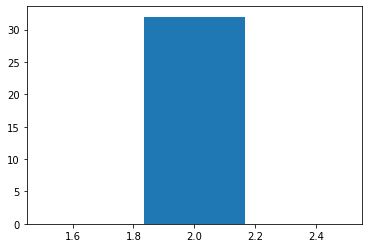

In [17]:
plt.hist(perf_model_small['course_id'],bins=3)

(array([ 6.,  7., 14., 89., 10.,  1.,  1.,  0.,  1.,  1.]),
 array([-0.44561764, -0.30511412, -0.1646106 , -0.02410708,  0.11639645,
         0.25689997,  0.39740349,  0.53790701,  0.67841053,  0.81891405,
         0.95941757]),
 <a list of 10 Patch objects>)

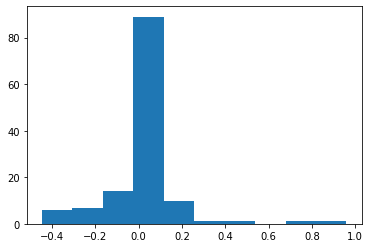

In [23]:
plt.hist(perf_model_small['T_coeff'])

(array([12.,  9.,  8.,  1.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 3.86180588,  7.97562529, 12.0894447 , 16.20326411, 20.31708353,
        24.43090294, 28.54472235, 32.65854176, 36.77236118, 40.88618059,
        45.        ]),
 <a list of 10 Patch objects>)

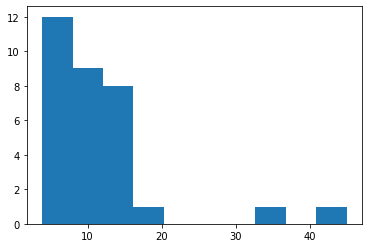

In [18]:
plt.hist(perf_model_small['mse'])

In [28]:
perf_model_df.to_csv('../../score_model_data/score_model3_fill0.csv')
len(perf_model_df)

306

(array([ 3.,  0.,  0.,  3., 24.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.40047521, -0.31930956, -0.23814391, -0.15697826, -0.07581262,
         0.00535303,  0.08651868,  0.16768433,  0.24884997,  0.33001562,
         0.41118127]),
 <a list of 10 Patch objects>)

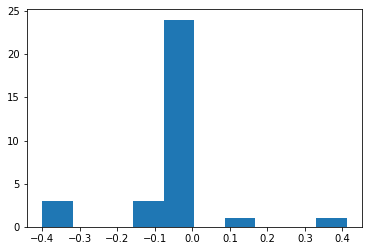

In [19]:
plt.hist(perf_model_small['cumgame_coeff'])

(array([ 1.,  2.,  1.,  3., 98., 10.,  7.,  3.,  3.,  2.]),
 array([-1.612861  , -1.23125564, -0.84965027, -0.46804491, -0.08643954,
         0.29516582,  0.67677119,  1.05837655,  1.43998192,  1.82158728,
         2.20319264]),
 <a list of 10 Patch objects>)

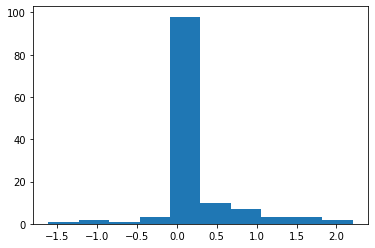

In [110]:
plt.hist(perf_model_small['precip_coeff'])

(array([20.,  5.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.18432175, 0.36864351, 0.55296526, 0.73728702,
        0.92160877, 1.10593053, 1.29025228, 1.47457403, 1.65889579,
        1.84321754]),
 <a list of 10 Patch objects>)

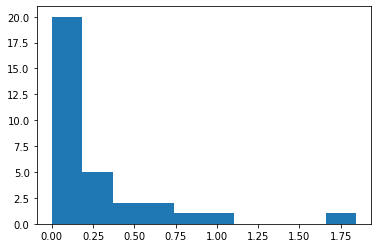

In [20]:
plt.hist(perf_model_small['wspd_coeff'])

(array([  2.,   2.,   0.,   9., 111.,   2.,   2.,   0.,   0.,   2.]),
 array([-4.92127176, -3.71600286, -2.51073396, -1.30546505, -0.10019615,
         1.10507275,  2.31034166,  3.51561056,  4.72087946,  5.92614837,
         7.13141727]),
 <a list of 10 Patch objects>)

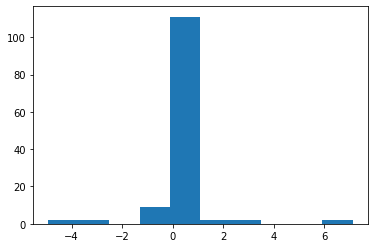

In [112]:
plt.hist(perf_model_small['wgust_coeff'])

(array([ 1.,  1.,  0.,  0.,  2., 26.,  1.,  0.,  0.,  1.]),
 array([-0.00222006, -0.00179848, -0.00137691, -0.00095534, -0.00053376,
        -0.00011219,  0.00030938,  0.00073095,  0.00115253,  0.0015741 ,
         0.00199567]),
 <a list of 10 Patch objects>)

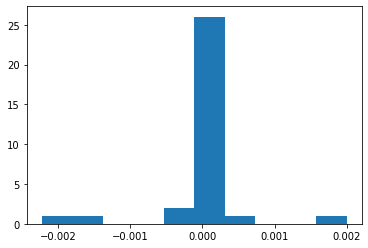

In [21]:
plt.hist(perf_model_small['dirvar_coeff'])

(array([62.,  8., 11.,  9., 15.,  4., 10.,  4.,  3.,  4.]),
 array([0.        , 0.09977297, 0.19954595, 0.29931892, 0.39909189,
        0.49886487, 0.59863784, 0.69841082, 0.79818379, 0.89795676,
        0.99772974]),
 <a list of 10 Patch objects>)

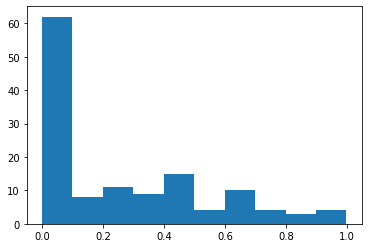

In [93]:
plt.hist(perf_model_small['prediction_score'])

In [22]:
zeros = []
coeff_count = []
for row in perf_model_small.iterrows():
    tmp_count = 0
    if row[1]['cumgame_coeff'] == 0:
        tmp_count += 1
    if row[1]['T_coeff'] == 0:
        tmp_count += 1
    if row[1]['precip_coeff'] == 0:
        tmp_count += 1
    if row[1]['wgust_coeff'] == 0:
        tmp_count += 1
    if row[1]['wspd_coeff'] == 0:
        tmp_count += 1
    if row[1]['dirvar_coeff'] == 0:
        tmp_count += 1
    zeros.append(tmp_count)
    coeff_count.append(6 - tmp_count)
perf_model_small['coeff_count'] = coeff_count
perf_model_small.head()

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
5,-0.104261,2,0.000000,0.000000,58.314393,10.627420,22.0,NaN,Bob Montes,0.00000,0.261497,0.0,0.338187,0.000000,2
8,-0.000000,2,-0.002045,-0.000110,53.127956,13.597416,53.0,NaN,Dennis Warsen,0.00000,0.146325,0.0,0.121373,0.173534,4
11,-0.133708,2,-0.018495,-0.000077,70.147133,6.612213,21.0,NaN,Gonzalo Arestizabal,0.00000,0.204586,0.0,0.106562,0.173227,5
20,-0.182483,2,-0.079464,-0.000000,64.935077,4.177045,24.0,NaN,Jon Braidman,735.27266,0.745534,0.0,0.308881,0.000000,4
26,-0.000000,2,0.000000,0.000000,61.080482,9.142118,14.0,NaN,Matt Rowe,0.00000,0.393209,0.0,-0.577363,-0.000000,1


In [124]:
perf_model_small.coeff_count.value_counts()

1    36
0    32
6    25
5    16
3    10
2     8
4     3
Name: coeff_count, dtype: int64

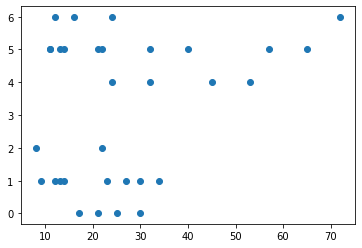

In [23]:
plt.scatter(x=perf_model_small.n_values, y=perf_model_small.coeff_count)

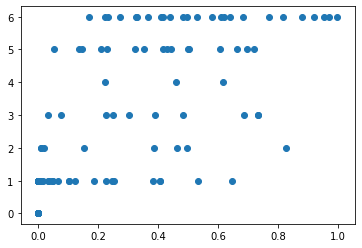

In [97]:
plt.scatter(x=perf_model_small.prediction_score, y=perf_model_small.coeff_count)

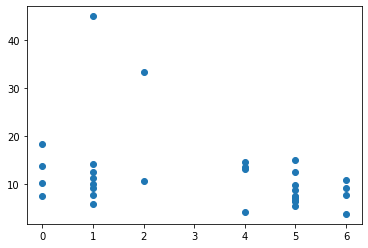

In [24]:
plt.scatter(x=perf_model_small.coeff_count, y=perf_model_small.mse)

In [99]:
perf_model_small.mse.mean()

10.452315295915565

In [25]:
perf_model_small.mean()

T_coeff             -0.048227
course_id            2.000000
cumgame_coeff       -0.037326
dirvar_coeff        -0.000061
intercept           59.645030
mse                 11.729837
n_values            26.531250
nomatch                   NaN
precip_coeff        28.202230
prediction_score     0.242903
removed_corr         0.000000
wgust_coeff          0.079031
wspd_coeff           0.233671
coeff_count          3.187500
dtype: float64

In [116]:
perf_model_small.std()

T_coeff              0.616687
course_id            0.862697
cumgame_coeff        0.641324
dirvar_coeff         0.722664
intercept            4.570438
mse                  6.667738
n_values            10.798352
nomatch                   NaN
precip_coeff         0.493877
prediction_score     0.284360
removed_corr         0.000000
wgust_coeff          1.200517
wspd_coeff           0.930452
coeff_count          2.326944
dtype: float64

In [117]:
perf_model_small[['player','course_id','mse','coeff_count']].sort_values(by='mse')

,player,course_id,mse,coeff_count
1035,Thor Scordelis,0,0.039730,6
564,Angel Diaz,0,0.699637,6
678,Marquis Oliver,0,0.778662,6
843,Life Gibson,0,0.892499,6
789,Chris Johengen,0,1.474757,6
969,Jake Ward,0,1.505148,6
1023,Marquis Mallen,0,1.664741,6
1074,Randy Waters,0,1.707004,2
6,Dennis Warsen,0,1.771189,5
798,Dan Santini,0,1.776207,1


In [118]:
perf_model_small.sort_values(by='prediction_score',ascending=False).head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
1035,3.025132,0,1.621453,3.396717,61.000000,0.039730,8.0,NaN,Thor Scordelis,0.707049,0.997730,0.0,-4.837434,3.701202,6
564,2.482084,0,2.687337,-0.228159,61.555556,0.699637,9.0,NaN,Angel Diaz,-1.612861,0.969466,0.0,7.131417,-1.901484,6
678,-0.661196,0,-1.907324,2.640225,50.250000,0.778662,8.0,NaN,Marquis Oliver,1.320051,0.952629,0.0,1.090662,0.791047,6
338,0.660755,2,0.481537,4.336724,54.461538,2.313548,13.0,NaN,Roger Cansler,0.221834,0.918983,0.0,3.095013,3.361994,6
789,1.619776,0,0.341778,3.015356,55.928571,1.474757,14.0,NaN,Chris Johengen,1.526033,0.880606,0.0,-4.921272,6.008541,6


In [26]:
bh = all_df[all_df['Name'] == 'Dan Santini']
bh = bh.reset_index()
bh = bh.drop(columns=['index'])
bh = bh.reset_index()
bh.plot('index','Raw')

TypeError: Empty 'DataFrame': no numeric data to plot

In [133]:
single_factor = perf_model_small.loc[perf_model_small.coeff_count == 2]

In [139]:
single_factor.precip_coeff.value_counts()

0.0    8
Name: precip_coeff, dtype: int64

In [140]:
perf_model_df.mean()

T_coeff             -0.041013
course_id            1.000000
cumgame_coeff        0.129255
dirvar_coeff         0.132558
intercept           61.086230
mse                  4.339172
n_values             5.129983
nomatch              1.000000
precip_coeff         0.162414
prediction_score     0.237434
removed_corr         0.306759
wgust_coeff          0.133709
wspd_coeff           0.177784
dtype: float64

In [141]:
perf_model_df.std()

T_coeff             0.616687
course_id           0.816784
cumgame_coeff       0.952388
dirvar_coeff        0.719974
intercept           8.406107
mse                 6.233948
n_values            7.541465
nomatch             0.000000
precip_coeff        0.492182
prediction_score    0.281911
removed_corr        0.649123
wgust_coeff         1.195949
wspd_coeff          0.926999
dtype: float64

In [149]:
precip_impute = perf_model_small.loc[perf_model_small.precip_coeff != 0]
precip_impute = precip_impute.loc[abs(perf_model_small.precip_coeff) > 0.000001]
precip_impute.head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff,coeff_count
5,-0.364219,2,-0.000000,0.000000,55.043478,9.719677,23.0,NaN,Bob Montes,0.429569,0.303480,0.0,1.249596,0.000000,3
6,-0.077912,0,0.154197,-0.000000,51.300000,1.771189,10.0,NaN,Dennis Warsen,0.047364,0.321383,0.0,0.265456,0.128399,5
7,-2.609247,1,-0.470259,0.000000,57.142857,5.063019,14.0,NaN,Dennis Warsen,0.607129,0.685965,0.0,0.000000,0.000000,3
32,-0.000000,2,-0.000000,-0.000000,61.575758,16.680231,66.0,NaN,Pete D'Agostino,0.208133,0.032708,0.0,0.010714,0.006259,3
41,0.063723,2,-0.185487,0.300831,55.222222,10.812143,72.0,NaN,Steve Willis,1.042084,0.326838,0.0,0.595565,0.803346,6


In [150]:
precip_impute.mean()

T_coeff              0.094812
course_id            0.395833
cumgame_coeff        0.297392
dirvar_coeff         0.356800
intercept           58.091210
mse                  6.657330
n_values            15.187500
nomatch                   NaN
precip_coeff         0.443254
prediction_score     0.478528
removed_corr         0.000000
wgust_coeff          0.073367
wspd_coeff           0.480665
coeff_count          4.625000
dtype: float64

In [151]:
precip_impute.std()

T_coeff              0.866505
course_id            0.791970
cumgame_coeff        0.953636
dirvar_coeff         1.059127
intercept            4.609539
mse                  4.167727
n_values            12.603033
nomatch                   NaN
precip_coeff         0.736818
prediction_score     0.262789
removed_corr         0.000000
wgust_coeff          1.689816
wspd_coeff           1.325817
coeff_count          1.829138
dtype: float64

In [152]:
T_impute = perf_model_small.loc[perf_model_small.T_coeff != 0]
T_impute = T_impute.loc[abs(T_impute.T_coeff) > 0.0001]
T_impute.mean()['T_coeff'], T_impute.std()['T_coeff']

(-0.09873381460447614, 0.9590803567746171)

In [154]:
len(T_impute)

54

In [155]:
perf_model_with_zeros = perf_model_df.fillna(0)
perf_model_with_zeros.head()

,T_coeff,course_id,cumgame_coeff,dirvar_coeff,intercept,mse,n_values,nomatch,player,precip_coeff,prediction_score,removed_corr,wgust_coeff,wspd_coeff
0,0.0,0,0.0,0.0,0.000000,0.000000,0.0,1.0,Ben Horst,0.0,0.0,0.0,0.0,0.0
1,0.0,1,0.0,0.0,0.000000,0.000000,0.0,1.0,Ben Horst,0.0,0.0,0.0,0.0,0.0
2,0.0,2,-0.0,-0.0,68.111111,16.320988,9.0,0.0,Ben Horst,0.0,0.0,1.0,0.0,0.0
3,0.0,0,0.0,0.0,0.000000,0.000000,0.0,1.0,Bob Montes,0.0,0.0,0.0,0.0,0.0
4,0.0,1,0.0,0.0,52.600000,6.640000,5.0,0.0,Bob Montes,0.0,0.0,0.0,0.0,0.0


In [27]:
perf_model_with_zeros.to_csv('../../score_model_data/score_model3_fill0.csv')
len(perf_model_with_zeros)

NameError: name 'perf_model_with_zeros' is not defined

In [4]:
X = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
y = [1, 3, 3]
scaler = StandardScaler()
lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, 
                max_iter = 5000, random_state=42)
pipeline = make_pipeline(scaler, lr)
pipeline.fit(X,y)
ypred = pipeline.predict(X)
model_dict = pipeline.score(X,y)
scaled_coeff = pipeline['elasticnetcv'].coef_ 
coeff_tuple = np.true_divide(scaled_coeff, pipeline['standardscaler'].scale_)

C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\envs\discgolf\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positi

In [29]:
len(all_df)

987

In [31]:
len(scores_df)

3795

In [32]:
len(wx_df)

182

In [33]:
all_df.course_id.value_counts()

2    987
Name: course_id, dtype: int64

In [37]:
wx_df.tail(60)

,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
118,2018-10-31,62.948844,23.714286,0.047279,0.866667,73.268537,0.000000,-0.044281,0.007999,2.766984,2906.489796,21570.948844,2
78,2018-11-01,62.600000,252.000000,0.300000,1.100000,73.600000,0.000000,-0.285317,-0.092705,0.000000,0.000000,0.000000,2
109,2018-11-03,61.275516,50.101190,0.084524,1.395238,82.966270,0.000000,-0.078940,0.028955,3.749977,6867.546060,34624.825287,2
58,2018-11-10,57.664815,97.037037,0.141414,3.444444,39.723906,0.000000,-0.111111,-0.030303,2.024691,9425.305213,15856.319469,2
121,2018-11-17,54.737626,195.205387,1.248148,5.555556,73.492088,0.000000,-1.154808,-0.337791,4.913580,4512.913025,18105.220640,2
173,2018-11-24,57.877134,245.086151,3.726449,13.333333,91.914855,0.000000,-3.337005,-1.469337,5.555556,11.256267,70.355091,2
161,2018-12-01,54.531481,284.212963,3.828704,14.222222,79.773148,0.011250,-3.441065,1.425205,15.506173,27.406421,251.489097,2
62,2018-12-08,56.412963,226.231481,1.476852,6.777778,73.527778,0.000000,-0.490765,-0.236393,0.617284,2660.227666,1869.263959,2
101,2018-12-15,60.712037,187.990741,1.462963,7.666667,71.925926,0.000000,0.295400,-0.964825,3.555556,2728.305470,12191.060508,2
164,2018-12-22,52.423611,241.662037,1.120370,5.000000,77.226852,0.000000,-1.019794,0.242745,0.666667,1452.706962,1516.163901,2
